# Psience Examples

This is a hopefully growing set of examples of what can be done with Psience. The examples will mostly be self-contained(?) and might include some degree of exploration/development ideas. At a minimum, they should complement the unit tests to provide a starting point for working with the libraries.

## Configure Examples Environment

In [1]:
import sys
import os
import importlib
import numpy as np
import scipy
import json
np.set_printoptions(linewidth=1e8, suppress=True)

import McUtils.Plots as plt
from McUtils.Data import UnitsData
import McUtils.Numputils as nput
from Psience.Molecools import Molecule

import Psience
class TestManager:
    projects_dir = os.path.expanduser("~/Documents/Postdoc/Projects/")
    test_dir = os.path.join(os.path.dirname(Psience.__file__), "ci", "tests", "TestData")
    @classmethod
    def test_data(cls, filename):
        return os.path.join(cls.test_dir, filename)
    @classmethod
    def project_data(cls, filename):
        return os.path.join(cls.projects_dir, filename)
    
    @classmethod
    def load_module(cls, module):
        if module in sys.modules:
            from McUtils.Jupyter import ModuleReloader
            ModuleReloader(module).reload()
        return importlib.import_module(module)
    @classmethod
    def import_from(cls, module, names, set_glob=True):
        mod = cls.load_module(module)
        objs = []
        single = isinstance(names, str)
        if single: names = [names]
        for name in names:
            obj = getattr(mod, name)
            if set_glob:
                globals()[name] = obj
            objs.append(obj)
        if single: objs = objs[0]
        return objs

def parse_x3d_view_matrix(vs, view_all=True):
    #vs from JSON.stringify(document.getElementById('x3d').runtime.viewMatrix())
    vm = json.loads(vs)
    vm = np.linalg.inv([
        [vm[f"_{i}{j}"] for j in range(4)]
        for i in range(4)
    ])
    ang, ax = nput.extract_rotation_angle_axis(vm[:3, :3])
    v_pos = vm[:3, -1].tolist()
    v_ort = np.array(list(ax) + [ang]).tolist()
    opts = {"position":v_pos, "orientation":v_ort}
    if view_all:
        opts['viewAll'] = True
    return opts

### Edge Graph Tests

In [153]:
import numpy as np
import collections
import scipy.sparse as sparse
import McUtils.Numputils as nput

In [206]:
Molecule = TestManager.import_from("Psience.Molecools", "Molecule")
ooc = Molecule.from_string("O-O-C", "smi", add_implicit_hydrogens=True)

In [211]:
ooc.plot(highlight_atoms=[0, 1, 2, 4, 5, 6], return_objects=False)

In [215]:
np.asarray(ooc.coords[(0, 1, 2),])

array([[ 2.74615707, -1.04527076,  0.30898777],
       [ 0.50300851, -1.7121612 , -0.46351693],
       [-1.30781376,  0.14872769, -0.00120321]])

In [220]:
nput = TestManager.load_module("McUtils.Numputils")
n = 2
# rand_coords = np.random.rand(4 + n, 3)
rand_coords = np.asarray(ooc.coords[(0, 1, 2, 4, 5, 6),])
Y = 0 + n
X1 = 1 + n
X2 = 2 + n
X3 = 3 + n
R1 = n - 1
R2 = n - 2
R3 = n - 3
d_rand = nput.internal_coordinate_tensors(
    rand_coords,
    [
        [Y, X1],
        [Y, X2],
        [Y, X3],
        [X1, Y, X2],
        [X1, Y, X3],
        [X2, Y, X3],
        [R1, Y],
        [X1, Y, R1, X2],
        [X2, Y, R1, X3],
        [X3, Y, R1, X1],
        [R2, R1],
        [R2, R1, Y],
        [R3, R2],
        [R3, R2, R1]
        # [0, 1, Y],
    ],
    angle_ordering="ijk",
)
d_rand.shape, np.linalg.eigvalsh(d_rand.T @ d_rand)

((18, 14),
 array([-0.        , -0.        ,  0.03124727,  0.07272811,  0.16004023,  0.53344948,  1.04275037,  1.11075687,  1.19983041,  1.69982972,  2.34011662,  3.08884352,  5.09997234,  5.16915689]))

In [158]:
h2o = EdgeGraph(["O", "H", "H"], [[0, 1], [0, 2]])
ohh = EdgeGraph(["O", "H", "H"], [[0, 1], [1, 2]])

In [160]:
aaaa = EdgeGraph(anion_nitro.atoms, anion_nitro.bonds)

In [167]:
perm = np.pad(1 + np.argsort(np.random.randint(0, 1000, len(anion_nitro.atoms) - 1)), [1, 0])
inv = np.argsort(perm)
perm_nitro = Molecule(
    [anion_nitro.atoms[a] for a in perm], 
    anion_nitro.coords[perm,],
    bonds=[[inv[i], inv[j]] for i,j in anion_nitro.bonds]
)
bbbb = EdgeGraph(perm_nitro.atoms, perm_nitro.bonds)

In [168]:
EdgeGraph.graph_match(aaaa, bbbb)

True

## TestPlots

In [ ]:
from McUtils.Jupyter import ModuleReloader
ModuleReloader("McUtils.Plots").reload()
ModuleReloader("McUtils.Jupyter").reload()
import McUtils.Plots as plt

In [ ]:
grids = [
    np.meshgrid(
        np.linspace(r, r+2*np.pi, 250),
        np.linspace(-r, -r+2*np.pi, 250),
        indexing='ij'
    )
    for r in np.linspace(0, np.pi, 10)
]
frame_data = [
    np.cos(g[0]) * np.sin(g[1])
    for g in grids
]


fig = plt.ArrayPlot(frame_data[0], frame=[[None, None], [None, None]])
frames = [
    plt.ArrayPlot(frame, figure=fig)
    for frame in frame_data[1:]
]
fig.animate_frames(frames)

In [ ]:
from McUtils.Jupyter import X3DHTML, JHTML

JHTML.Figure(
    JHTML.Script(src='http://www.x3dom.org/download/x3dom.js'),
    JHTML.Link(rel='stylesheet', href='http://www.x3dom.org/download/x3dom.css'),
    X3DHTML.X3D(
        X3DHTML.Scene(
            JHTML.Input(type="range", value="0", min="0", max="1", step="1", cls="slider",
                        oninput="""document.getElementById("animation-frames").setAttribute("whichChoice", this.value)"""),
            X3DHTML.Switch(
                X3DHTML.Shape(
                    X3DHTML.Appearance(X3DHTML.Material(diffuseColor='red')),
                    X3DHTML.Sphere()
                ),
                X3DHTML.Shape(
                    X3DHTML.Appearance(X3DHTML.Material(diffuseColor='blue')),
                    X3DHTML.Sphere()
                ),
                whichChoice="0",
                id="animation-frames"
            )
            
        )
    ),
    width='500px',
    height='500px'
)

## VPT

In [2]:
from Psience.VPT2 import *

### test_HOHAnalytic

In [5]:
file_name = "HOH_freq.fchk"
runner, states = AnalyticVPTRunner.construct(
    TestManager.test_data(file_name),
    [[
        0,
        [[0, 0, 1]]
    ]],
    # expressions_file=os.path.expanduser("~/Desktop/exprs.hdf5")
)
classic, _ = runner.construct_classic_runner(states)
mat_wfns = classic.print_tables()
atp_corrs = runner.run_VPT(states)

>>------------------------- calculating G-matrix derivatives -------------------------
:: took 0.000s...
>>--------------------------------------------------<<
>>------------------------- calculating potential derivatives -------------------------
:: prepping grad...
:: Cartesian transformation...
:: handling mixed derivative symmetry (MixedDerivativeHandlingModes.Analytical)...
:: checking Hessian...
:: took 0.015s...
>>--------------------------------------------------<<
>>------------------------- calculating dipole derivatives -------------------------
:: took 0.008s
>>--------------------------------------------------<<
>>------------------------- Computing PT corrections: -------------------------
:: states: 2
:: order: 2
:: expansion order: 2
::> getting representations
  > trying to load from checkpoint...
  > failed to load, building instead...
  ::> getting basis
    > trying to load from checkpoint...
    > fail to load, building instead...
    > getting states for H(1)|n(0)

### test_AnalyticWFC

In [6]:
file_name = "OCHH_freq.fchk"
AnalyticVPTRunner.run_simple(
    TestManager.test_data(file_name),
    [
        [
            0,
            [
                [0, 0, 0, 0, 0, 1],
                [0, 1, 0, 1, 0, 0],
                [0, 0, 0, 1, 1, 0],
                [0, 0, 0, 0, 1, 0],
            ],
        ],
        [
            [0, 0, 0, 0, 1, 0],
            [
                [0, 0, 0, 0, 1, 1],
                [0, 1, 0, 1, 1, 0]
            ]
        ]
    ],
    degeneracy_specs='auto',
    handle_degeneracies=True
)

>>------------------------- calculating G-matrix derivatives -------------------------
:: took 0.000s...
>>--------------------------------------------------<<
>>------------------------- calculating potential derivatives -------------------------
:: prepping grad...
:: Cartesian transformation...
:: handling mixed derivative symmetry (MixedDerivativeHandlingModes.Analytical)...
:: checking Hessian...
:: took 0.019s...
>>--------------------------------------------------<<
>>------------------------- calculating dipole derivatives -------------------------
:: took 0.013s
>>--------------------------------------------------<<
>>------------------------- Getting corrections at order 0 -------------------------
::> Building evaluator W[0][()]
  > took 0.000s
<::
::> evaluating...
  > took 0.000s
<::
>>--------------------------------------------------<<
>>------------------------- Getting corrections at order 0 -------------------------
::> Building evaluator W[0][(1, -1)]
  > took 0.000s

AnalyticPerturbationTheoryCorrections(states=BasisStateSpace(nstates=7, basis=HOBasis(dim=6)), state_lists=[[[[0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0], [0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 1, 0]]], [[[0, 0, 0, 0, 1, 0]], [[0, 0, 0, 0, 1, 1], [0, 1, 0, 1, 1, 0]]]], _energies=array([0.02636274, 0.03934586, 0.03921411, 0.05172128, 0.04691512, 0.0398846 , 0.05255284]), _transition_moments=[[array([[ 0.        ,  0.        ,  0.        , -0.00000002]]), array([[0., 0.]])], [array([[-0.03782846, -0.0306695 , -0.        , -0.00000201]]), array([[-0.05043127, -0.01788934]])], [array([[ 0.00000247, -0.000002  ,  0.00498506, -0.0375401 ]]), array([[-0.00000037, -0.00000344]])]], _spectra=[[<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef252d5a00>], [<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef252fc550>]], _deperturbed_energies=array([0.02636274, 0.03956124, 0.03921411, 0.05181577, 0.04691512, 0.03966922, 0.05245835]), _deperturbed

### test_OCHHMultiple

Run starting from multiple initial states with automatic degeneracy handling

In [7]:
file_name = "OCHH_freq.fchk"
runner, states = AnalyticVPTRunner.construct(
    TestManager.test_data(file_name),
    [
        [
            0,
            [
                [0, 0, 0, 0, 0, 1],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 2, 0, 0]
            ],
        ],
        [
            [
                [0, 0, 0, 0, 0, 1],
            ],
            [
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 2, 0, 0]
            ],
        ]
    ],
    degeneracy_specs='auto'
    # degeneracy_specs=[
    #             [[0, 0, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0]]
    #         ],
    # degeneracy_specs={
    #     'polyads': [
    #         [
    #             [0, 0, 0, 0, 0, 1],
    #             [0, 0, 0, 0, 1, 0]
    #         ],
    #         [
    #             [0, 0, 0, 0, 0, 1],
    #             [0, 1, 0, 1, 0, 0]
    #         ]
    #     ]
    # }
)
classic, _ = runner.construct_classic_runner(states,
                                             zero_element_warning=False
                                             )
classic.print_tables()
runner.run_VPT(states)

>>------------------------- calculating G-matrix derivatives -------------------------
:: took 0.000s...
>>--------------------------------------------------<<
>>------------------------- calculating potential derivatives -------------------------
:: prepping grad...
:: Cartesian transformation...
:: handling mixed derivative symmetry (MixedDerivativeHandlingModes.Analytical)...
:: checking Hessian...
:: took 0.018s...
>>--------------------------------------------------<<
>>------------------------- calculating dipole derivatives -------------------------
:: took 0.013s
>>--------------------------------------------------<<
>>------------------------- Getting corrections at order 0 -------------------------
>>------------------------- Building evaluator W[0][()] -------------------------
:: took 0.000s
>>--------------------------------------------------<<
::> evaluating...
  > took 0.000s
<::
>>--------------------------------------------------<<
>>------------------------- Getting c

AnalyticPerturbationTheoryCorrections(states=BasisStateSpace(nstates=5, basis=HOBasis(dim=6)), state_lists=[[[[0, 0, 0, 0, 0, 0]], [[0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 1, 0], [0, 0, 0, 2, 0, 0], [0, 1, 0, 1, 0, 0]]], [[[0, 0, 0, 0, 0, 1], [0, 1, 0, 1, 0, 0]], [[0, 0, 0, 0, 1, 0], [0, 0, 0, 2, 0, 0]]]], _energies=array([0.02636274, 0.03934586, 0.03921411, 0.04172755, 0.0398846 ]), _transition_moments=[[array([[ 0.        , -0.00000002, -0.        ,  0.        ]]), array([[-0.,  0.],
       [ 0.,  0.]])], [array([[-0.03782846, -0.00000201,  0.        , -0.0306695 ]]), array([[-0.01743934, -0.00333539],
       [-0.01342639, -0.00059361]])], [array([[ 0.00000247, -0.0375401 , -0.01037231, -0.000002  ]]), array([[ 0.00000104, -0.00000004],
       [-0.00000127,  0.00000004]])]], _spectra=[[<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef24604bb0>], [<Psience.Psience.Spectra.BaseSpectrum.DiscreteSpectrum object at 0x7fef25ef5790>, <Psience.Psience.Spectra.BaseSpectrum.Disc

## Molecular Visualization

### Load NH3

In [ ]:
TestManager.import_from("Psience.Molecools", "Molecule")

nh3 = Molecule.from_file(
    TestManager.test_data("nh3.fchk"),
    internals=[
        [0, -1, -1, -1],
        [1,  0, -1, -1],
        [2,  0,  1, -1],
        [3,  0,  1,  2]
    ],
    bonds=[
        [0, 1],
        [0, 2],
        [0, 3]
    ]
)
nh3

### Animate Dihedral

#### Simplified

It's so common to want to animate a given coordinate that I just added in a bespoke function for it...

In [ ]:
# I extracted a nice default viewmatrix from the X3D HTML element
vs = "{\"_00\":-0.9998172405453938,\"_01\":0.018742171764957148,\"_02\":-0.0037704781839175533,\"_03\":1.4745149545802857e-17,\"_10\":-0.003051418775696821,\"_11\":-0.35114503482210363,\"_12\":-0.9363161076064184,\"_13\":1.8034076836037622e-15,\"_20\":-0.01887258200824471,\"_21\":-0.9361334816773265,\"_22\":0.35113804996187,\"_23\":-5.482585044070595,\"_30\":0,\"_31\":0,\"_32\":0,\"_33\":0.9999999999999998}"
viewpoint = parse_x3d_view_matrix(vs)

nh3.animate_coordinate(5, view_settings=viewpoint)

#### Better Control

In [ ]:
coord_expansion = nh3.get_cartesians_by_internals(2, strip_embedding=True)

geoms = nh3.get_scan_coordinates(
    [[-.3, .3, 10]],
    which=[5],
    coordinate_expansion=coord_expansion
)
geoms = np.concatenate([geoms, np.flip(geoms, axis=0)], axis=0)

# I extracted a nice default viewmatrix from the X3D HTML element
vs = "{\"_00\":-0.9998172405453938,\"_01\":0.018742171764957148,\"_02\":-0.0037704781839175533,\"_03\":1.4745149545802857e-17,\"_10\":-0.003051418775696821,\"_11\":-0.35114503482210363,\"_12\":-0.9363161076064184,\"_13\":1.8034076836037622e-15,\"_20\":-0.01887258200824471,\"_21\":-0.9361334816773265,\"_22\":0.35113804996187,\"_23\":-5.482585044070595,\"_30\":0,\"_31\":0,\"_32\":0,\"_33\":0.9999999999999998}"
viewpoint = parse_x3d_view_matrix(vs)

nh3.plot(geoms, view_settings=viewpoint, return_objects=False)

## Molecule Formats

In [89]:
from McUtils.Data import UnitsData

In [142]:
TestManager.load_module("McUtils.ExternalPrograms")
TestManager.import_from("Psience.Molecools", "Molecule")

ccc = Molecule.from_string("CCC", "smi", 
                           add_implicit_hydrogens=True, 
                           internals=[b[:2] for b in ccc.bonds]
                          )
# ccc.animate_coordinate(5)

In [143]:
ccc.g_matrix

[array([[ 0.00009143, -0.00001367, -0.00001562, -0.00001715, -0.00001562, -0.00001496, -0.00001589,  0.        ,  0.        ,  0.        ],
        [-0.00001367,  0.00009143,  0.        ,  0.        ,  0.        , -0.00001749, -0.00001665, -0.00001835, -0.00001491, -0.00001431],
        [-0.00001562,  0.        ,  0.00059004, -0.00001187, -0.000019  ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00001715,  0.        , -0.00001187,  0.00059004, -0.00001191,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00001562,  0.        , -0.000019  , -0.00001191,  0.00059004,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.00001496, -0.00001749,  0.        ,  0.        ,  0.        ,  0.00059004, -0.00001272,  0.        ,  0.        ,  0.        ],
        [-0.00001589, -0.00001665,  0.        ,  0.        ,  0.        , -0.00001272,  0.00059004,  0.        ,  0.        ,  0.        ],
        [ 0.        

In [4]:
TestManager.load_module("McUtils.ExternalPrograms")
TestManager.import_from("Psience.Modes", "EdgeGraph")

mol = Molecule.from_file(
    TestManager.project_data("2DIR/freq_anion_12_11.fchk")
)
mol.bonds = mol.rdmol.bonds
mol.rdmol.rings

((12, 2, 0, 8, 15), (18, 8, 0, 9, 21), (24, 9, 0, 3, 27), (2, 1, 0), (3, 1, 0))

In [69]:
vm = parse_x3d_view_matrix("{\"_00\":-0.18544862833983825,\"_01\":0.9334430170087512,\"_02\":-0.30707155557698484,\"_03\":-0.1930534715181078,\"_10\":0.8384947084198391,\"_11\":-0.012623886972170956,\"_12\":-0.544763491278227,\"_13\":0.9682956575401015,\"_20\":-0.5123821134649438,\"_21\":-0.3585035166847202,\"_22\":-0.7803459478499788,\"_23\":-32.75498005772947,\"_30\":0,\"_31\":0,\"_32\":0,\"_33\":0.9999999999999944}")

In [73]:
vm

{'position': [-17.63077819500415, -11.550347469799654, -25.092005066773886],
 'orientation': [-0.6356574254425159,
  -0.7006721703256035,
  0.3240341759922875,
  2.9945536707471234],
 'viewAll': True}

In [ ]:
mol.plot(
    highlight_atoms=[25],
    view_settings=vm,
    return_objects=False
)

In [55]:
TestManager.load_module("McUtils.Numputils")
Molecule = TestManager.import_from("Psience.Molecools", "Molecule")

# ccc = Molecule.from_string("CCC", "smi", add_implicit_hydrogens=True, internals={'primitives':'auto', 'nonredundant_coordinates':[(0, 1)]})
# ccc_atoms = ccc.atoms
# ccc_coords = ccc.coords
ccc = Molecule(ccc_atoms, ccc_coords, internals={'primitives':'auto', 'base_coords':[(0, 1)]})
ccc.animate_coordinate(0)
# red_tf = ccc.internal_coordinates.converter_options['redundant_transformation']

(33, 33) (33, 1) (33, 31)


In [ ]:
ccc.get_internals_by

In [12]:
ccc_zm_coords = [
            (0, 1),
            (0, 1, 2),
            (1, 2),
            (10, 2),
            (10, 2, 1),
            (3, 0),
            (3, 0, 1),
            (3, 0, 1, 2),
            (4, 0),
            (4, 0, 1),
            (4, 0, 1, 2),
            (5, 0),
            (5, 0, 1),
            (5, 0, 1, 2),
            (6, 1),
            (6, 1, 0),
            (6, 1, 0, 2),
            (7, 1),
            (7, 1, 0),
            (7, 1, 0, 2),
            (8, 2),
            (8, 2, 1),
            (8, 2, 1, 0),
            (9, 2),
            (9, 2, 1),
            (9, 2, 1, 0),
            (10, 2, 1, 0),
    ]

In [52]:
ccc.get_cartesians_by_internals(1)[0] @ ccc.get_cartesians_by_internals(1)[0].T

array([[ 2.22826726, -0.10164996, -0.03179429, -0.01126331, -0.13821469,  0.03866925,  0.11001103, -0.1835368 , -0.0039459 , -0.46732955, -0.01671797, -0.01980217,  0.05815366, -0.00640114, -1.27443266,  0.15894821, -0.30109381, -0.76955222, -0.97871147, -0.21622375,  0.28313004, -0.79193736,  0.30752308, -0.2541155 , -0.01327868, -2.33508061],
       [-0.10164996,  0.52347378,  0.00899978, -0.00279003, -0.00426362,  0.0003969 ,  0.05449893,  0.02464323, -0.00010304,  0.0072366 ,  0.00404126, -0.0017295 ,  0.00151123, -0.00057893,  0.01418143, -0.03524937, -0.08209744, -0.12393136,  0.01197496,  0.01583322,  0.10560248,  0.04563381, -0.0341299 ,  0.00480689, -0.06783908,  0.74604465],
       [-0.03179429,  0.00899978,  0.64286471,  0.00054075,  0.00253996, -0.00731973, -0.00006439,  0.00012346, -0.00028875,  0.00316607, -0.06208944, -0.03212441, -0.01735893,  0.00502206,  0.03606192,  0.28709627,  0.13132714, -0.06552993,  0.02968988, -0.03267746,  0.01154918, -0.01074119, -0.06388124,

In [50]:
(ccc.get_cartesians_by_internals(1)[0] @ ccc.get_internals_by_cartesians(1)[0]).shape

(26, 26)

In [35]:
ccc_3 = Molecule(
    ccc_atoms,
    ccc_coords,
    internals={
        "specs": ccc_zm_coords, 
        'base_coords':[(0, 1)]
    },
)  # {'specs':'auto', 'base_coords':[(0, 3)]})
ccc.get_cartesians_by_internals(1)[0] @ ccc_3.get_internals_by_cartesians(1)[0]
# ccc_3.animate_coordinate(0)

array([[ 1.        , -0.        , -0.29845768,  0.        ,  0.        , -0.        ,  0.        , -0.        , -0.        ,  0.        ,  0.        ,  0.        ,  0.        , -0.        ,  0.        ,  0.        ,  0.        , -0.        , -0.        , -0.        ,  0.        , -0.        ,  0.        , -0.        , -0.        ,  0.        , -0.        ],
       [-0.        ,  0.        , -0.00750254,  0.        , -0.        ,  1.        ,  0.        ,  0.        ,  0.        , -0.        , -0.        ,  0.        , -0.        ,  0.        ,  0.        ,  0.        , -0.        , -0.        ,  0.        ,  0.        , -0.        ,  0.        , -0.        , -0.        ,  0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.02349216, -0.        , -0.        ,  0.        ,  0.        ,  0.        ,  1.        , -0.        ,  0.        , -0.        ,  0.        , -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,

In [274]:
ccc_2 = Molecule(ccc_atoms, ccc_coords, internals=[
    [0, -1, -1, -1],
    [1,  0, -1, -1],
    [2,  1,  0, -1],
    [3,  0,  1,  2],
    [4,  0,  1,  2],
    [5,  0,  1,  2],
    [6,  1,  0,  2],
    [7,  1,  0,  2],
    [8,  2,  1,  0],
    [9,  2,  1,  0],
    [10, 2,  1,  0],
])
ccc_2.get_internals_by_cartesians(1, strip_embedding=True)[0][:, 0]

array([ 0.86546744, -0.18885007, -0.46400615, -0.86546744,  0.18885007,  0.46400615,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [ ]:
ccc_3 = Molecule(
    ccc_atoms,
    ccc_coords,
    internals={
        "primitives": [
            (0, 1),
            (0, 1, 2),
            (1, 2),
            (10, 2),
            (10, 2, 1),
            (3, 0),
            (3, 0, 1),
            (3, 0, 1, 2),
            (4, 0),
            (4, 0, 1),
            (4, 0, 1, 2),
            (5, 0),
            (5, 0, 1),
            (5, 0, 1, 2),
            (6, 1),
            (6, 1, 0),
            (6, 1, 0, 2),
            (7, 1),
            (7, 1, 0),
            (7, 1, 0, 2),
            (8, 2),
            (8, 2, 1),
            (8, 2, 1, 0),
            (9, 2),
            (9, 2, 1),
            (9, 2, 1, 0),
            (10, 2, 1, 0),
        ],
        "nonredundant_coordinates": [(0, 1)],
    },
)  # {'specs':'auto', 'base_coords':[(0, 3)]})
ccc_3.animate_coordinate(0)

In [253]:
ccc_4.internals

NameError: name 'ccc_4' is not defined

In [ ]:
ccc_4 = Molecule(ccc_atoms, ccc_coords, internals={"primitives":"auto",
                                                  "nonredundant_coordinates":[(0,1)]
                                                  })#{'specs':'auto', 'base_coords':[(0, 3)]})
ccc_4.animate_coordinate(0)

## Coordinate Utils

## Experimental Developments

In [3]:
import scipy.sparse as sparse

def build_coord_graph(natoms, bonds):
    adj = np.zeros((natoms, natoms), dtype=bool)
    bonds = np.asanyarray(bonds)
    rows = bonds[:, 0]; cols = bonds[:, 1]
    adj[rows, cols] = 1
    adj[cols, rows] = 1
    
    return sparse.csr_matrix(adj)
def _get_shortest_path(sp_data, i, j):
    lens, preds = sp_data
    n = int(lens[i, j])
    path = np.empty(n + 1, dtype=int)
    path[-1] = j
    k = j
    for c in range(1, n+1):
        prev = preds[i, k]
        path[-(c+1)] = prev
        k = prev
    # if preds[i, k] != j:
    #     raise ValueError(i, j, k)
    return path
def shortest_path_function(graph):
    lens, preds = sparse.csgraph.shortest_path(graph, return_predecessors=True, unweighted=True, directed=False)
    def shortest_path(i, j, data=(lens.astype('uint64'), preds)):
        return _get_shortest_path(data, i, j)
    return shortest_path
def find_rings(csgraph):
    return sparse.csgraph.shortest_path(csgraph, return_predecessors=True, unweighted=True, directed=False)
# def get_path(shortest_path_data, start, end):
    
adj_graph = build_coord_graph(len(anion_nitro.atoms), anion_nitro.bonds)
shorts = shortest_path_function(adj_graph)

In [36]:
TestManager.load_module("McUtils.Plots")
TestManager.import_from("Psience.Molecools", "Molecule")

anion_nitro = Molecule.from_file(
    os.path.expanduser("~/Documents/Postdoc/Projects/2DIR/freq_anion_12_11.fchk"),
    internals=[
        (4, 7),
        (5, 10),
        (6, 11),
        (4, 7, 0),
        (5, 10, 1),
        (6, 11, 1),
        (0, 1, 7),
        (1, 0, 10),
        (1, 0, 11),
        (0, 1),
        (0, 7),
        (0, 10),
        (0, 11),
        (1, 7),
        (2, 0, 1),
        (3, 0, 1),
        (1, 10),
        (1, 11),
        (0, 2),
        (0, 3),
        (1, 2),
        (1, 3),
        (2, 0, 1, 3),
        
        [0, 8],
        [0, 9],
        [0, 8, 9],
        
        [1, 10],
        [1, 11],
        [1, 10, 11],
        
        [2, 12],
        [3, 27],
        
        [8, 15],
        [8, 18],
        [8, 30],
        [8, 15, 18],
        [8, 15, 30],
        [8, 18, 30],
        
        [9, 21],
        [9, 24],
        [9, 34],
        [9, 21, 24],
        [9, 21, 34],
        [9, 24, 34],
        
        [12, 13],
        [12, 14],
        [12, 15],
        [12, 13, 14],
        [12, 13, 15],
        [12, 14, 15],
        
        [15, 16],
        [15, 17],
        
        [18, 19],
        [18, 20],
        [18, 21],
        [18, 19, 20],
        [18, 20, 21],
        [18, 19, 21],
        
        [21, 22],
        [21, 23],
        
        [24, 25],
        [24, 26],
        [24, 27],
        [24, 25, 26],
        [24, 25, 27],
        [24, 26, 27],
        
        [27, 28],
        [27, 29],
        
        [30, 31],
        [30, 32],
        [30, 33],
        [30, 31, 32],
        [30, 31, 33],
        [30, 32, 33],
        
        [34, 35],
        [34, 36],
        [34, 37],
        [34, 35, 36],
        [34, 35, 37],
        [34, 36, 37]
    ],
    bonds = [
        [0, 1],
        [0, 2],
        [0, 3],
        [0, 7],
        [0, 8],
        [0, 9],
        [1, 2],
        [1, 3],
        [1, 10],
        [1, 11],
        [2, 12],
        [3, 27],
        [4, 7],
        [5, 10],
        [6, 11],
        [8, 15],
        [8, 18],
        [8, 30],
        [9, 21],
        [9, 24],
        [9, 34],
        [12, 13],
        [12, 14],
        [12, 15],
        [15, 16],
        [15, 17],
        [18, 19],
        [18, 20],
        [18, 21],
        [21, 22],
        [21, 23],
        [24, 25],
        [24, 26],
        [24, 27],
        [27, 28],
        [27, 29],
        [30, 31],
        [30, 32],
        [30, 33],
        [34, 35],
        [34, 36],
        [34, 37]
    ]
)

In [153]:
# [
#     [vm["_00"], vm["_01"], vm["_02"], vm["_03"]], 
#     [vm["_10"], vm["_11"], vm["_12"], vm["_13"]], 
#     [vm["_20"], vm["_21"], vm["_22"], vm["_23"]], 
#     [vm["_30"], vm["_31"], vm["_32"], vm["_33"]]
# ]
vm = np.linalg.inv(np.array([
    [0.9358276821426781, -0.11722393716520674, -0.3323929871266098, -1.4474224478006057e-7], 
    [0.3297524300579383, -0.04181700432252693, 0.9431408553447224, -4.998895758445697e-8], 
    [-0.12445836334431928, -0.9922247158305308, -0.0004786320881147166, -18.54214433793241], 
    [0, 0, 0, 1]
]))
ang, ax = nput.extract_rotation_angle_axis(vm[:3, :3])
v_pos = vm[:3, -1].tolist()
v_ort = np.array(list(ax) + [ang]).tolist()

In [ ]:
# cart_conv = anion_nitro.get_cartesians_by_internals(2)
extent = .1
steps = 10
displacements = np.linspace(-extent, extent, 10)
displacements = np.concatenate([displacements, np.flip(displacements)]).reshape(-1, 1)
geoms = anion_nitro.get_displaced_coordinates(
    displacements,
    which=[5],
    coordinate_expansion=cart_conv
)
 
anion_nitro.plot(
    geoms,
    view_settings={
        'position': v_pos,
        'orientation': v_ort
    },
    # highlight_rings=[(0, 1, 2), (0, 1, 3)],
    highlight_atoms=[11, 6, 1],
    highlight_bonds=[(11, 6), (11, 1)],
    # highlight_atoms=set(range(len(anion_nitro.atoms))) - {11, 6, 1},
    # highlight_bonds=[
    #     b for b in anion_nitro.bonds 
    #     if not (b[0] in {11, 6, 1} and b[1] in {11, 6, 1})
    # ],
    # highlight_styles={"glow":"#777777"},
    image_size=[1000, 500]
)[0]

In [211]:
int_conv = anion_nitro.get_internals_by_cartesians(2)
cart_conv = anion_nitro.get_cartesians_by_internals(2)
internal_tensors = nput.tensor_reexpand(cart_conv, [0, anion_nitro.potential_derivatives[1]])

In [12]:
F_internal = internal_tensors[1]
G_internal = int_conv[0].T @ np.diag(np.repeat(1 /
                                     anion_nitro.atomic_masses, 3))  @ int_conv[0]
n = 3
redund_vals, redund_tf = np.linalg.eigh(G_internal[n:, n:])
redund_modes = np.abs(redund_vals) > 1e-10
redund_tf = redund_tf[:, redund_modes]
Q_redund = np.concatenate(
    [
        np.pad(np.eye(n), [[0, redund_tf.shape[0]], [0, 0]]),
        np.pad(redund_tf, [[n, 0], [0, 0]])
    ],
    axis=1
)
F_redund = Q_redund.T @ F_internal @ Q_redund
G_redund = Q_redund.T @ G_internal @ Q_redund

In [17]:
cart_disp_redund = (Q_redund.T @ cart_conv[0])

In [ ]:
def render_frame(disp):
    return X3DGroup(anion_nitro.plot(
        anion_nitro.coords + np.dot(np.array(disp), cart_disp_redund).reshape(-1, 3), 
        backend='x3d'
    )[0].figure.to_x3d().children[0].children)

structs = [
    render_frame([0, 0, 0, r] + [0]*(cart_disp_redund.shape[0]-4))
    for r in np.linspace(-.3, 0, 10)
]
    

X3D(
    X3DScene(
        X3DListAnimator(
            *(structs + list(reversed(structs))),
            animation_duration=1
        )
    ),
    width='100%',
    height='600px'
).to_widget()

In [206]:
(Q_redund[:, :6] ** 2) * 100

array([[100.        ,   0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        , 100.        ,   0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        , 100.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   6.09998461,  40.15261899,  21.62846816],
       [  0.        ,   0.        ,   0.        ,   0.0093499 ,   1.35695374,   2.25517153],
       [  0.        ,   0.        ,   0.        ,   2.34594346,  23.47140309,  26.43712082],
       [  0.        ,   0.        ,   0.        ,   0.50982596,  10.16424204,   0.88810502],
       [  0.        ,   0.        ,   0.        ,   0.96234173,   2.41835042,   7.93096692],
       [  0.        ,   0.        ,   0.        ,   0.01890238,   0.04776283,   2.78627757],
       [  0.        ,   0.        ,   0.        ,   0.28293862,   2.28862077,   7.81601591],
       [  0.        ,   0.        ,   0.        ,   0.5523244 ,   2.20

In [201]:
freq2, nm_tf = scipy.linalg.eigh(F_redund, G_redund, type=3)
np.sqrt(freq2) * UnitsData.convert("Hartrees", "Wavenumbers")

array([ 126.95727292,  210.82572103,  266.98429126,  278.06657356,  292.92142224,  311.7749483 ,  318.29353989,  383.27316577,  559.89322328,  615.85775714,  662.07329879,  691.640496  , 1594.61289377, 1611.5225415 , 1683.49465145])

In [ ]:
nm_tf

In [199]:
G_redund[:6, :6]

array([[ 0.00007347,  0.        ,  0.        , -0.00000213,  0.00000323,  0.00000334],
       [ 0.        ,  0.00007347,  0.        ,  0.00000138,  0.00000176, -0.00000274],
       [ 0.        ,  0.        ,  0.00007347, -0.00000052, -0.0000008 ,  0.00000044],
       [-0.00000213,  0.00000138, -0.00000052,  0.00000378,  0.        , -0.        ],
       [ 0.00000323,  0.00000176, -0.0000008 ,  0.        ,  0.00000655, -0.        ],
       [ 0.00000334, -0.00000274,  0.00000044, -0.        , -0.        ,  0.00000967]])

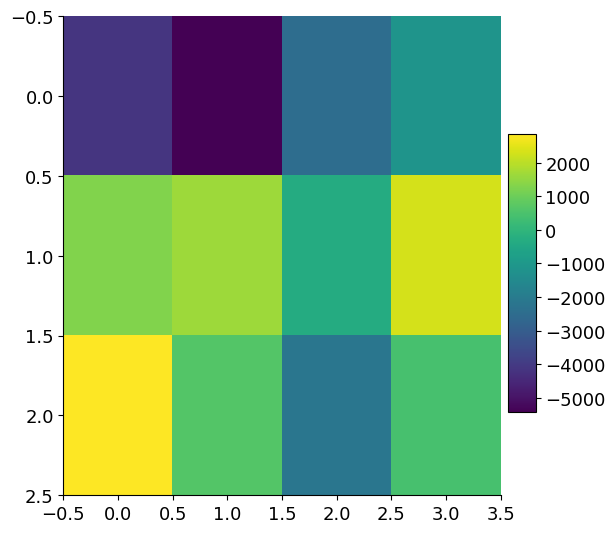

In [210]:
plt.ArrayPlot(
    F_redund[:3, 4:8] * UnitsData.convert("Hartrees", "Wavenumbers"), colorbar=True)

[1551.87525318 1512.89930708 1598.898428    362.76117619  425.53019189  540.9125101   321.65126048  433.8023248   275.72021504  406.34390107  312.68489607  596.00502816  667.84563759  784.63469641  781.02760052]


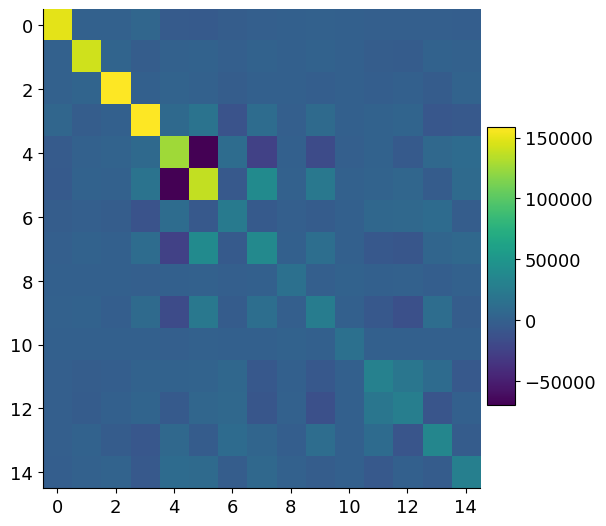

In [195]:
loc_freq = np.sqrt(np.diag(F_redund * G_redund))
print(loc_freq * UnitsData.convert("Hartrees", "Wavenumbers"))
plt.ArrayPlot(F_redund * UnitsData.convert("Hartrees",
              "Wavenumbers"), colorbar=True)

In [ ]:
loc_freq = np.sqrt(np.diag(
    internal_tensors[1] * G_internal)) * UnitsData.convert("Hartrees", "Wavenumbers")
backbone_freqs, Q_freqs = scipy.linalg.eigh(
    F_internal[3:, 3:], G_internal[3:, 3:], type=2)
print(backbone_freqs * UnitsData.convert("Hartrees", "Wavenumbers"))
print(loc_freq * UnitsData.convert("Hartrees", "Wavenumbers"))
plt.ArrayPlot(F_internal * UnitsData.convert("Hartrees",
              "Wavenumbers"), colorbar=True)

In [156]:
F_internal[:3]

array([[149349.08385137,   1417.16235467,   1247.14510068,  -6785.92274008,    500.44569654,    -71.85667296,    249.16459632,   4863.11834243,   1031.691762  ,   -193.96324099,  -1666.78180958,   -717.02616341,   -379.22641609,    384.66718403,    481.25399831,   1076.96400248,   1178.97700628,   3065.32324814],
       [  1417.16235467, 141941.37086136,   3972.7738129 ,   2080.19304407,   -675.98220776,    886.84987393,   -964.35236555,   -638.41544414,    983.32959771,    255.14852299,    446.83846429,   5874.24463196,     74.29594904,   -283.44972827,   -201.13327882,    -94.2947657 ,   -121.78096757,  -1891.1786959 ],
       [  1247.14510068,   3972.7738129 , 158537.02287136,   2444.15384774,   1315.65760939,    809.92554067,  -2914.21044732,     92.84589032,    470.12854016,   2273.7878008 ,   -428.79697089,   -239.11918075,   4483.69997573,    359.63419267,    445.65584177,    836.92354567,    761.46866017,    515.56839805]])

In [214]:
nitrosyl, _, _ = anion_nitro.plot(backend='x3d')
nitrosyl

In [ ]:
329704.77847410034
32073.705873395294

In [ ]:
plt.ArrayPlot(internal_tensors[1], colorbar=True)

In [109]:
G_nitro = np.linalg.inv(
    derivs[0] @ np.diag(np.repeat(anion_nitro.atomic_masses, 3)) @ derivs[0].T)

In [91]:
np.sqrt(np.diag(internal_tensors[1] * G_nitro)) * \
    UnitsData.convert("Hartrees", "Wavenumbers")

array([1602.33017805, 1586.88593318, 1664.60421917])

In [89]:
f2, _ = scipy.linalg.eigh(
    internal_tensors[1],
    G_nitro,
    type=2
)

In [90]:
np.sqrt(f2) * UnitsData.convert("Hartrees", "Wavenumbers")

array([1579.45556283, 1602.54360868, 1671.45154827])

In [98]:
m_inv = np.diag(1/np.repeat(np.sqrt(anion_nitro.atomic_masses), 3))
mw_F = m_inv @ anion_nitro.potential_derivatives[1] @ m_inv
np.sqrt(np.linalg.eigvalsh(mw_F)[6:]) * \
    UnitsData.convert("Hartrees", "Wavenumbers")

array([  42.69885546,   48.50022449,   53.61396474,   60.29776772,
         66.51531129,   73.55274346,   81.7311022 ,  103.98082747,
        112.24712959,  118.91899459,  129.47607522,  137.24489423,
        153.66787266,  163.13178563,  191.88394543,  212.85889614,
        220.13540973,  225.9305723 ,  236.47811242,  246.43278741,
        254.32372981,  258.30922124,  274.64123867,  279.91581781,
        293.02630906,  298.16009576,  325.95959688,  337.52618609,
        353.61766815,  363.91455962,  376.8793604 ,  406.33936568,
        410.73033406,  429.37331008,  510.09601737,  516.78300832,
        559.83353731,  564.04417009,  585.33223637,  615.42696574,
        617.11059675,  619.65041214,  664.36449825,  723.99748163,
        725.23700191,  741.31926022,  831.52053023,  853.35052242,
        898.16058941,  911.9579656 ,  926.1154229 ,  938.40101433,
        978.14302503, 1001.58663329, 1010.54966458, 1023.55274769,
       1036.36872252, 1073.25020118, 1086.94728508, 1099.83847